<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Описание проекта**

**Заказчик**: Компания онлайн заказа такси. Описание: компания собрала исторические данные о заказах такси в аэропортах.

**Задача**: спрогнозировать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки

**Цель**: построить модель, решающую задачу классификации для такого предсказания. Значение метрики RMSE на тестовой выборке должно быть не больше 48.

**Данные:** Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
from pathlib import Path

#data manipulation
import pandas as pd
import numpy as np

#stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

#data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

#ML
rs = 1512
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Расширение экрана
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30
pd.set_option('max_colwidth', 200)
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 50)

import warnings
warnings.filterwarnings('ignore')

#constant_random_state
rs = 1512

In [2]:
path_dir = Path(".")
try:
    df = pd.read_csv(Path(path_dir, 'taxi.csv'), index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

In [3]:
display(df.head(),
        df.shape,
        df.info(),
        df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


(26496, 1)

None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [4]:
def pass_value(df): # пропущенные значения бары
    """
    Функция для визуализации пропусков
    """
    (
        (df.isna().mean()*100)
        .to_frame()
        .rename(columns = {0:'space'})
        .query('space > 0')
        .sort_values(by = 'space', ascending = False)
        .plot(kind= 'bar', figsize=(20,5))
    );

In [5]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.
    :param df: Набор данных для вычисления статистики.
    :return: Датафрейм со статистикой распределения пропусков.
    """
    na = df.isna().sum()
    result = pd.DataFrame(data={"Кол-во уникальных": df.nunique(),
                                "Кол-во заполненных": df.shape[0] - na,
                                "Кол-во пропусков": na,
                                "Доля пропусков, %": 100 * na / df.shape[0],
                                "Тип": df.dtypes})
    print(f"Total rows = {df.shape[0]}")
    print(f"Total NA-values = {na.sum()}")
    if na.sum() != 0:
        pass_value(df)
    else:
        pass
    return result

In [6]:
check_missings(df)

Total rows = 26496
Total NA-values = 0


,Кол-во уникальных,Кол-во заполненных,Кол-во пропусков,"Доля пропусков, %",Тип
num_orders,81,26496,0,0.0,int64


In [7]:
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [8]:
if df.index.is_monotonic:
    print('Данные подготовлены, можно приступать к анализу.')
else:
    print('Данные преобразованы некорректно')

Данные подготовлены, можно приступать к анализу.


## Анализ

Проведем анализ данных

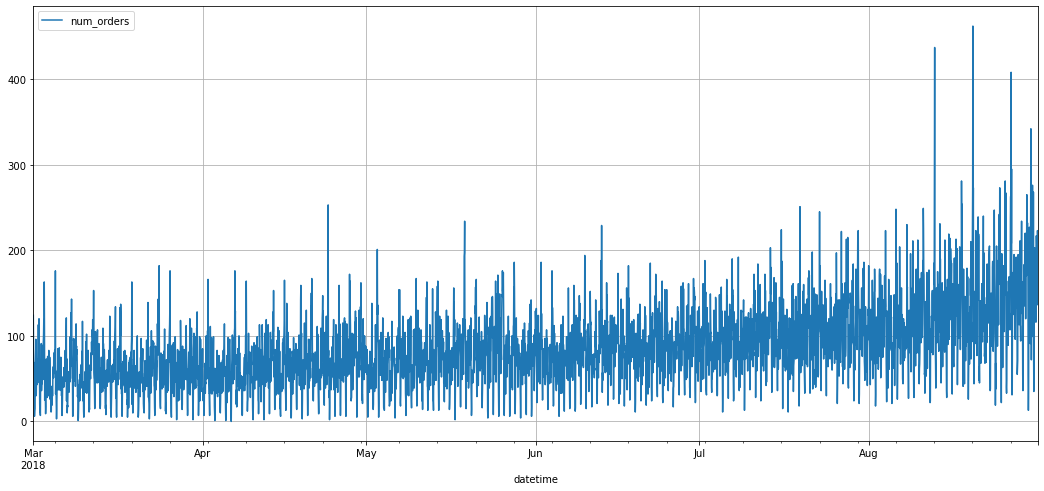

In [9]:
df.plot(figsize=(18,8),
        grid=True,);

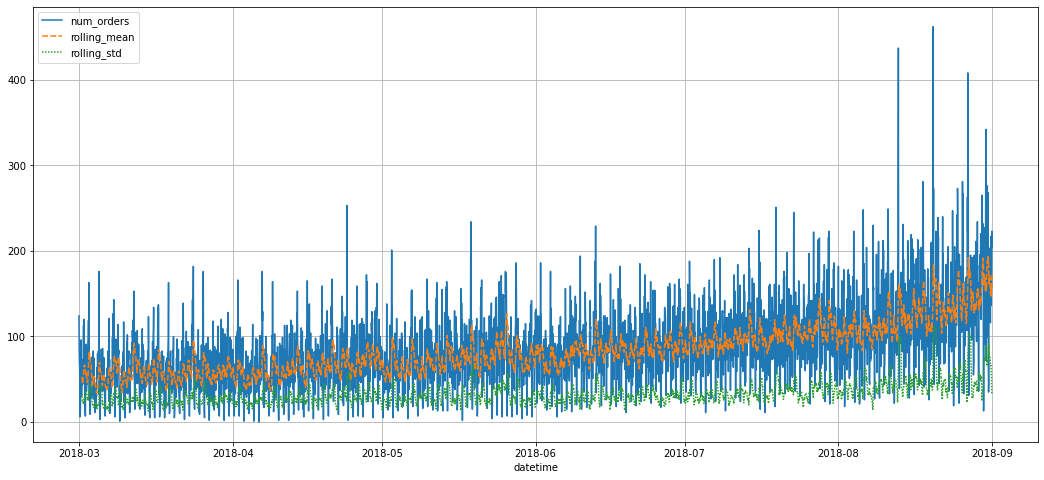

In [10]:
for_visual = df.copy()
for_visual["rolling_mean"] = for_visual["num_orders"].rolling(15).mean()
for_visual["rolling_std"] = for_visual["num_orders"].rolling(15).std()
fig, ax = plt.subplots(figsize=(18, 8))
sns.lineplot(data=for_visual, ax=ax)
plt.grid()
plt.show()

Посмотрим на разность временного ряда

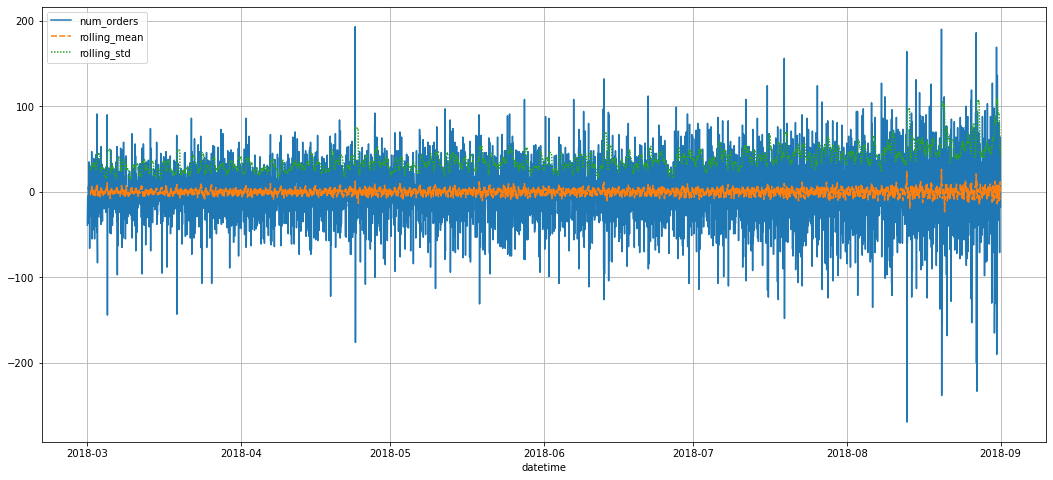

In [11]:
for_visual_shifted = df.copy()
for_visual_shifted -= for_visual_shifted.shift()
for_visual_shifted["rolling_mean"] = for_visual_shifted["num_orders"].rolling(15).mean()
for_visual_shifted["rolling_std"] = for_visual_shifted["num_orders"].rolling(15).std()
fig, ax = plt.subplots(figsize=(18, 8))
sns.lineplot(data=for_visual_shifted, ax=ax)
plt.grid()
plt.show()

In [12]:
#проверка на стационарность временного ряда

df_test_result = adfuller(df['num_orders'],
                          regression='ct',
                          maxlag=24,
                          store=True,
                          regresults=True)

print('p-value: %f' % df_test_result[1])
print('Critical Values:')
for key, value in df_test_result[2].items():
    print('%s: %.3f' % (key, value))

p-value: 0.000012
Critical Values:
1%: -3.961
5%: -3.411
10%: -3.128


In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
 
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
 
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
 
 
make_features(df, 24, 20)

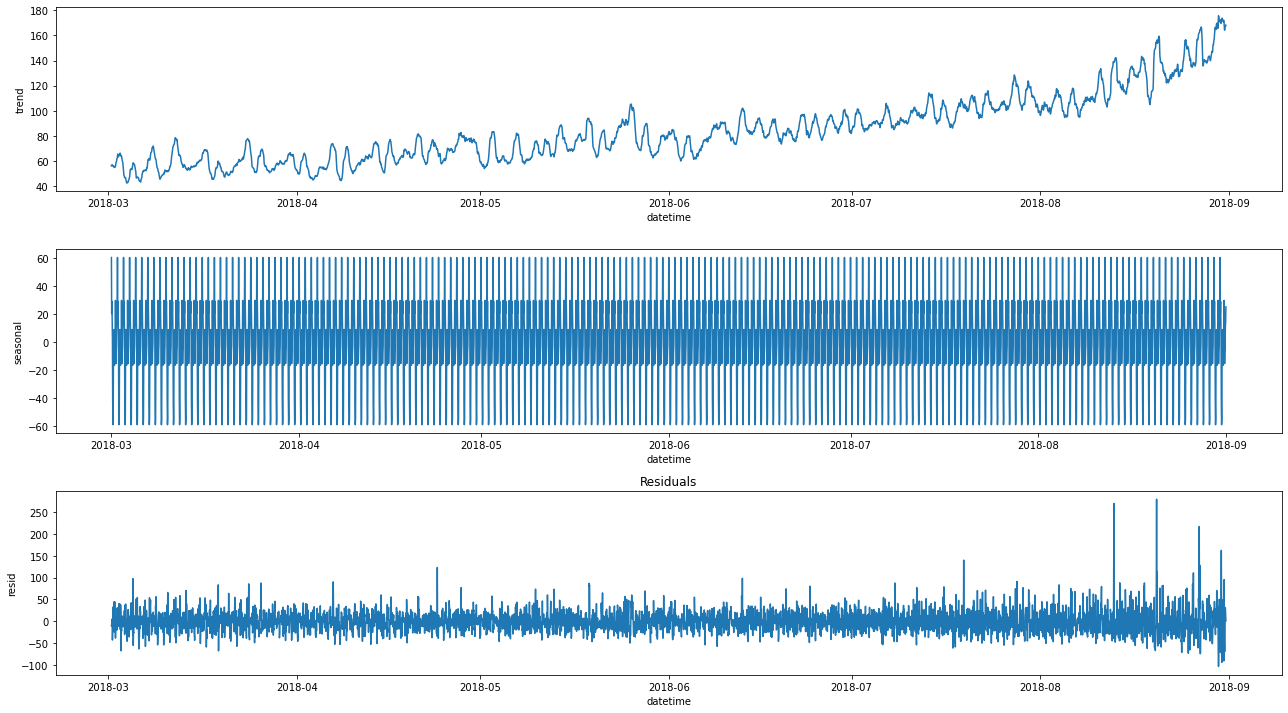

In [14]:
decomposed = seasonal_decompose(df.num_orders)

fig, ax = plt.subplots(3,1,figsize=(18, 10))
sns.lineplot(data=decomposed.trend, ax=ax[0])
plt.title('Trend')
sns.lineplot(data=decomposed.seasonal, ax=ax[1])
plt.title('Seasonality')
sns.lineplot(data=decomposed.resid, ax=ax[2])
plt.title('Residuals')
plt.tight_layout();

### Вывод

Временной ряд стационарный. Пройдена проверка Дики-Фуллера.

## Обучение

In [15]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
 
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
 
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [16]:
#RMSE
def RMSE(predictions, target):
    return np.sqrt(((predictions - target) ** 2).mean())
    
    
RMSE_score = make_scorer(RMSE, greater_is_better=False)

In [17]:
#CV
def model_select(model, params, features_train, target_train):
    grid = GridSearchCV(model,
                        param_grid = params,
                        cv=TimeSeriesSplit(n_splits=3),
                        scoring=RMSE_score,
                        n_jobs=-1)
    grid.fit(features_train,target_train)
    predict = grid.predict(features_train)
    best_params = grid.best_params_
    print("Модель обучена!", RMSE(predict, target_train), grid.best_params_)
    return RMSE(predict, target_train)

In [18]:
# # catboost
# cbr_params = {
#     'max_depth': [7,13],
#     'learning_rate': [0.1, 0.2],
# }

# cbr = model_select(CatBoostRegressor(random_state=rs),
#                    cbr_params,
#                    features_train,
#                    target_train,)

In [19]:
#lgbm
lgbm_params = {
    'n_estimators': [200,300],
    'max_depth': [12,13],
    'learning_rate': [0.05, 0.1]
}

lgbm = model_select(LGBMRegressor(random_state=rs),
                    lgbm_params,
                    features_train,
                    target_train,)

Модель обучена! 12.50994890272161 {'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 200}


In [20]:
#random_forest
rfr_params = {'n_estimators': [100, 200],
             'max_depth': range (9,11)}

rfr = model_select(RandomForestRegressor(random_state=rs),
                   rfr_params,
                   features_train,
                   target_train,)

Модель обучена! 14.559716130243531 {'max_depth': 10, 'n_estimators': 100}


In [21]:
xgb_params = {
    'n_estimators': [100,200,300],
    'max_depth': [3,5,7],
    'learning_rate': [0.05, 0.1]
}

xgb = model_select(XGBRegressor(random_state=rs),
                    xgb_params,
                    features_train,
                    target_train,)

Модель обучена! 13.220298032137691 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300}


### Вывод

In [22]:
model_list = [lgbm, xgb, rfr]
index_list = ['LightGBM', 'XGBoost', 'RandomForest']
column_list = ['Learning_time', 'Predictions_time', 'RMSE']

In [23]:
models = pd.DataFrame(model_list,
                      columns=['RMSE'],
                      index=index_list)
models.sort_values('RMSE')
models

,RMSE
LightGBM,12.509949
XGBoost,13.220298
RandomForest,14.559716


### Вывод

Лучше всех на тренировочный выборке показала себя модель LGBMRegressor с результатом **RMSE=12.5**

## Тестирование

Проверим лучшую модель на тестовой выборке

In [24]:
lgbm = LGBMRegressor(learning_rate=0.05,
                     max_depth=12,
                     n_estimators=200,
                     random_state=rs)
lgbm.fit(features_train, target_train)
lgbm_pred = lgbm.predict(features_test)
lgbm_rmse = RMSE(target_test, lgbm_pred)
print(lgbm_rmse)

42.08256084510242


### Вывод

На тестовой выборке модель регрессии библиотеки LGBM отработала хорошо. **RMSE=42**, что удовлетворяет условиям заказчика. 

## Вывод

Были проанализированы модели для прогнозирования временных рядов и получены слудеющие результаты:<br><br>
*На обучающей выборке*:<br>
LightGBM: **12.5**<br>
XGBoost: **13.2**<br>
RandomForest: **14.55**<br>

*На тестовой выборке*:<br>
Лучшей моделью признана **LightGBM Regressor**<br>
LightGBM: **42**<br>